In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls /content/gdrive    #!ls


Mounted at /content/gdrive
MyDrive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

BATCH_SIZE = 32   #the number of training examples utilized in one iteration. here,we have take only 32 samples from dataset as our batchsize.
IMAGE_SIZE = 64
CHANNELS = 3
EPOCHS = 5



In [ ]:
ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/gdrive/MyDrive/EuroSAT',
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 5763 files belonging to 3 classes.


In [ ]:
class_names = ds.class_names
class_names

['Pasture', 'Residential', 'River']

(32, 64, 64, 3)


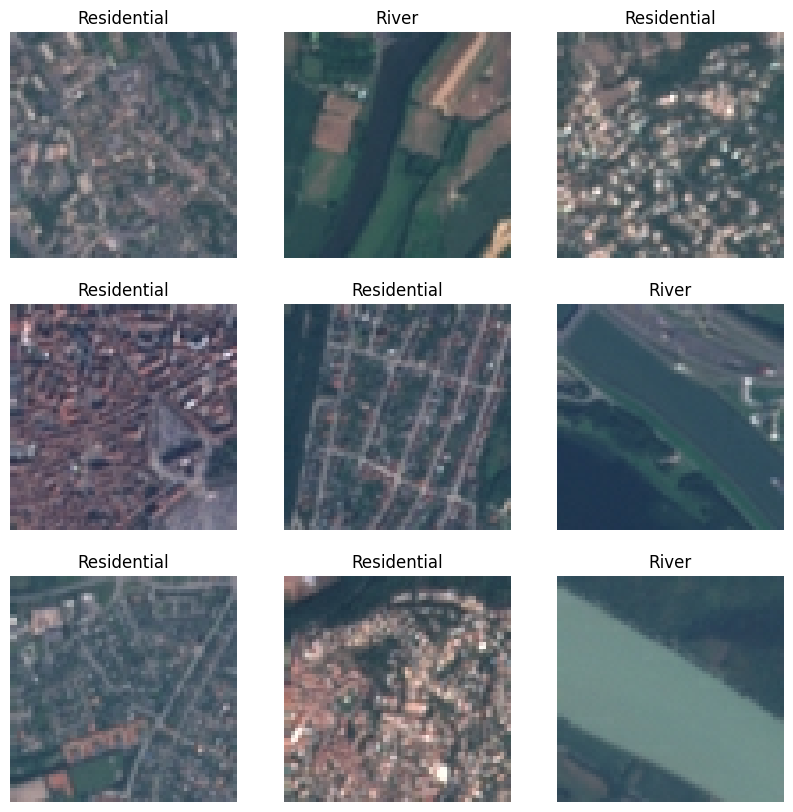

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in ds.take(1):
    print(image_batch.shape)
    for i in range(0,9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=500):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    if shuffle:
        train_ds = train_ds.shuffle(shuffle_size)
        val_ds = val_ds.shuffle(shuffle_size)
        test_ds = test_ds.shuffle(shuffle_size)

    return train_ds, val_ds, test_ds


In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomContrast(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2)
])

In [ ]:
input_shape= (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu',padding='same', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu',padding='same' ),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(ds)

train_ds = train_ds.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

history= model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/5
144/144 [==============================] - 929s 1s/step - loss: 0.5505 - accuracy: 0.7572 - val_loss: 0.3122 - val_accuracy: 0.9080
Epoch 2/5
144/144 [==============================] - 58s 374ms/step - loss: 0.3062 - accuracy: 0.9008 - val_loss: 0.3832 - val_accuracy: 0.8576
Epoch 3/5
144/144 [==============================] - 56s 359ms/step - loss: 0.2745 - accuracy: 0.9091 - val_loss: 0.3718 - val_accuracy: 0.8542
Epoch 4/5
144/144 [==============================] - 56s 358ms/step - loss: 0.2320 - accuracy: 0.9260 - val_loss: 0.2203 - val_accuracy: 0.9149
Epoch 5/5
144/144 [==============================] - 58s 362ms/step - loss: 0.2206 - accuracy: 0.9262 - val_loss: 0.2903 - val_accuracy: 0.9201


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                  

In [ ]:
print(ds)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
scores = model.evaluate(test_ds)

19/19 [==============================] - 56s 60ms/step - loss: 0.3478 - accuracy: 0.8929


In [ ]:
scores
history.params

{'verbose': 1, 'epochs': 5, 'steps': 144}

In [ ]:
history.history["loss"]
acc_hist = history.history["accuracy"]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

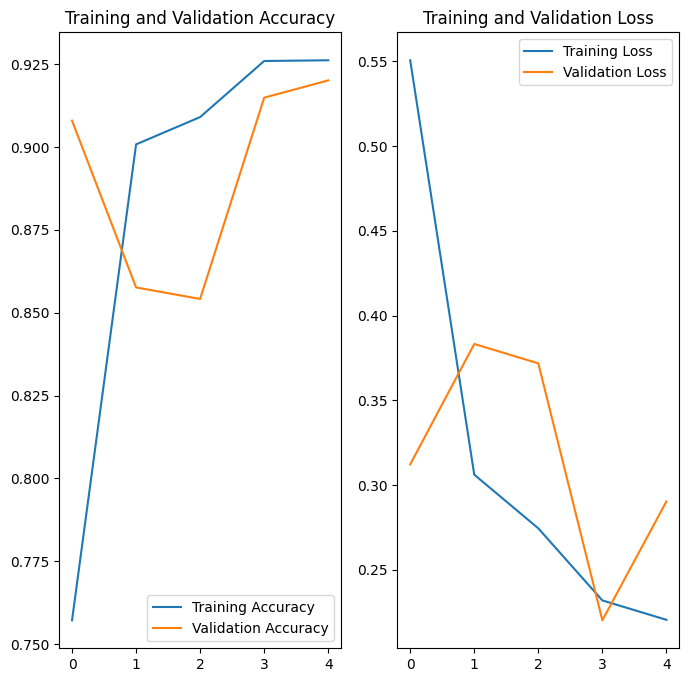

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save('/content/gdrive/MyDrive/saved_model/my_model')


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# Load the pre-trained VGG-16 model
new_model = tf.keras.models.load_model('/content/gdrive/MyDrive/saved_model/my_model')

# Ask the user for the image path
image_path = input("/content/gdrive/MyDrive/EuroSAT/River/River_10.jpg")

# Load the image and preprocess it for the VGG-16 model
test_image = image.load_img(image_path, target_size=(64, 64,3))

# Convert the image to a numpy array
test_image = image.img_to_array(test_image)

# Reshape the array to match the input shape of the model
test_image = np.expand_dims(test_image, axis=0)

# Normalize the pixel values of the image
test_image = test_image / (1./255)

# Predict the class label
predictions = new_model.predict(test_image)
#predicted_class =decode_predictions(predictions, top=1)[0][0]
print(predictions)
result = predictions[0]
answer = np.argmax(result)
#label = decode_predictions(predictions)
print(answer)

In [ ]:
import numpy as np
from sklearn.metrics import f1_score


# Load the saved CNN model
model = load_model('/content/gdrive/MyDrive/saved_model/my_model')

# Create a test data generator for evaluating the model
test_datagen = ImageDataGenerator(rescale=1./255)

eval_data = test_datagen.flow_from_directory(
        '/content/gdrive/MyDrive/EuroSAT',
        target_size=(224,224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)
y_pred = model.predict(eval_data)

# Convert predictions and true labels to binary arrays
y_pred_binary = np.argmax(y_pred)
y_true_binary = np.argmax(eval_data.labels)



In [ ]:
model.predict(test_ds)

In [ ]:
model.predict(val_ds)